# Recommender System: Amazon Review Data (2018)

#### by Robert Wienröder <br>

You can find the screencast for this project at the following location: <br>
https://cloud.bht-berlin.de/index.php/s/Ep5nRAjmjzcH7bC

I encountered difficulties when attempting to download the ratings dataset ("Movies_and_TV") directly. As a workaround, I utilized the Python package "requests" to save the dataset into a CSV file. Moreover, due to the less-than-optimal structure of the website, I have taken the liberty to upload the two datasets I utilized to the BHT Cloud. This will allow for convenient access and download of the datasets. Please find the datasets available for download at the following location: <br>
https://cloud.bht-berlin.de/index.php/s/Y7erYzQzcPyL8Yb

Original Datasets can be found here: <br>
https://nijianmo.github.io/amazon/index.html <br>


## Introduction

In this Jupyter Notebook, we present the implementation of a movie recommender system utilizing the "Amazon Review Data (2018)" dataset.

The primary aim of this project is to develop a robust recommender system capable of providing personalized movie recommendations tailored to individual user preferences.

## Abstract

Recommender systems play a crucial role in enhancing our daily lives by providing personalized recommendations tailored to individual user preferences and behaviors. These systems facilitate the discovery and selection of various items, including products, movies, music, articles, and more, catering to users' specific interests and needs.

The primary objective of this project is to develop a movie and TV show recommender system using the "Amazon Review Data (2018)" dataset. A comprehensive description of the dataset can be found in the subsequent section.

To achieve this goal, our recommender system will utilize Singular Value Decomposition (SVD), a matrix factorization technique. By decomposing the user-item matrix into lower-dimensional matrices, SVD enables us to reconstruct the original matrix and predict missing values effectively. To determine the most suitable parameters for the SVD model, we will employ grid search and cross-validation techniques.

However, a significant challenge associated with this dataset is its considerable size, which results in extensive training runtimes for the SVD algorithm. To overcome this obstacle, we will explore potential strategies to reduce the number of users and items considered during the analysis phase.

To assess the performance of our method, we will primarily rely on the Root Mean Square Error (RMSE) metric. Additionally, we will evaluate the quality of individual predictions for rated movies and the effectiveness of recommendations for unrated movies.

## Dataset Description

The "Amazon Review Data (2018)" dataset is an updated version of a previously released dataset from 2014. It contains reviews and product metadata for a wide range of Amazon products. However, for our project, we will be specifically working with the "ratings only" subset of the subset of movies and TV shows.

The "ratings only" subset consists of tuples with four variables: item ID, user ID, rating, and timestamp. This subset does not include any additional metadata or reviews associated with the products. Our analysis will primarily revolve around these essential rating data points.

Features of the dataset:
| Feature name | Type and description                       |
|--------------|--------------------------------------------|
| user       | str : User identifier (unique)             |
| item     | str : Item identifier (unique)           |
| rating | int : User's rating for the item (1-5)               |
| timestamp    | int: Time when rating was given |

As the temporal aspect of rating instances is not considered, the "timestamp" feature will be omitted from our data frame.

To enrich our recommender system and recommend movie titles instead of just item IDs, we will also utilize another dataset from the "Amazon Review Data (2018)" collection which is called "meta_Movies_and_TV". This dataset provides additional information about the products, but for our purposes, we will only use the item ID and the corresponding movie titles.

## Importing the used libraries

In [25]:
# Import libraries for data manipulation
import numpy as np
import pandas as pd
import copy
import random

# Import libraries for data loading
import json

# Import libraries for visualization
import matplotlib.pyplot as plt

# Import libraries for recommendation system algorithms
from surprise import Dataset, Reader, accuracy
from surprise.prediction_algorithms import SVD, KNNBaseline
from surprise.model_selection import GridSearchCV, train_test_split

## Dataset preparation

In this section, we will load the datasets into pandas dataframes and perform the necessary preparation steps for our recommender system.

#### Loading the "Ratings Only" Dataset

The initial step involves importing the "ratings only" dataset, which is available in the CSV file format. To ensure improved clarity and ease of analysis, we assign suitable column names to this dataset, considering that it lacks predefined headers. Additionally, as the timestamp information does not hold significance for our recommender system, we omit the corresponding column from the dataframe.

In [ ]:
# First of all we set a random seed for reproducibility
np.random.seed(42)

In [26]:
# Read CSV into pandas dataframe and name columns
movie_ratings = pd.read_csv('Movies_and_TV.csv', header=0, names=['itemid', 'userid', 'rating', 'timestamp']).drop('timestamp',axis=1)

# Print number of rows that corresponds to number of ratings
print(f"The movie_ratings dataframe contains {len(movie_ratings):,} ratings.")

# Show first 5 lines of dataframe
display(movie_ratings.head())

The movie_ratings dataframe contains 8,765,567 ratings.


,itemid,userid,rating
0,0001527665,A2VHSG6TZHU1OB,5.0
1,0001527665,A23EJWOW1TLENE,5.0
2,0001527665,A1KM9FNEJ8Q171,5.0
3,0001527665,A38LY2SSHVHRYB,4.0
4,0001527665,AHTYUW2H1276L,5.0


#### Loading the "meta_Movies_and_TV" Dataset
Moving forward, we proceed to import the "meta_Movies_and_TV" dataset, encompassing supplementary metadata pertaining to movies and TV shows. While this dataset encompasses a multitude of features, our attention will be directed towards extracting and filtering solely the item ID and movie title, both of which are crucial for our recommender system. The dataset is stored in a JSON file format, with each line representing a distinct dictionary.

In [27]:
# Read different dictionaries of json file into pandas dataframe
movie_titles_raw = []
with open('meta_Movies_and_TV.json', 'r') as f:
    for line in f:
        movie_titles_raw.append(json.loads(line))

# Select important columns and rename
movie_titles = pd.DataFrame(movie_titles_raw).filter(items=['title', 'asin']).rename(columns={'asin': 'itemid'})

# Show first 5 lines of dataframe
display(movie_titles.head())

,title,itemid
0,Understanding Seizures and Epilepsy,0000695009
1,Spirit Led&mdash;Moving By Grace In The Holy S...,0000791156
2,My Fair Pastry (Good Eats Vol. 9),0000143529
3,"Barefoot Contessa (with Ina Garten), Entertain...",0000143588
4,Rise and Swine (Good Eats Vol. 7),0000143502


#### Merging the Dataframes
To consolidate all the necessary information in a single dataframe, we merge the two dataframes. This merged dataframe will serve as the foundation for building our recommender system.

In [28]:
# Merge ratings dataframe with titles dataframe
complete_df = movie_ratings.merge(movie_titles, left_on='itemid', right_on='itemid')

# Show first 5 lines of dataframe
display(complete_df.head())

,itemid,userid,rating,title
0,0001527665,A2VHSG6TZHU1OB,5.0,Peace Child VHS
1,0001527665,A23EJWOW1TLENE,5.0,Peace Child VHS
2,0001527665,A1KM9FNEJ8Q171,5.0,Peace Child VHS
3,0001527665,A38LY2SSHVHRYB,4.0,Peace Child VHS
4,0001527665,AHTYUW2H1276L,5.0,Peace Child VHS


#### Assessing the size

We are dealing with a dataset consisting of 8.7 million rows, which corresponds to 8.7 million rating matrix entries. However, rating matrices typically exhibit sparsity, implying that the actual full rating matrix could contain multiple times the number of these 8.7 million entries. Therefore, we will assess the potential size of the full rating matrix.

In [29]:
# Calculate total numbers of users and items
total_users = len(complete_df["userid"].unique())
total_movies = len(complete_df["itemid"].unique())

# Calculate total number of full rating matrix and print it
full_matrix_entries = total_users * total_movies
print(f"Number of entries in the full rating matrix: {total_users:,} * {total_movies:,} = {full_matrix_entries:,}")

Number of entries in the full rating matrix: 3,823,915 * 181,828 = 695,294,816,620


## Data Selection

In this section we aim to reduce the number of data points based on meaningful criteria.

#### Analyzing movie counts

Considering the entirety of the movies and TV shows dataset, the resulting matrix would encompass an extensive number of entries, approximately reaching 670 billion. However, due to computational limitations, generating such a rating matrix and predicting ratings for all entries would be very time-consuming. Even though we are not aiming to fill an entire rating matrix in this project, the size of the resulting rating matrix still is a good estimator for the computational complexity of the task. We opt to limit the data to a subset comprising a specific number of movies and users. It proves advantageous to exclude movies and users with sparse ratings, as predictions for them may exhibit reduced accuracy and contribute limited information to the algorithm. In order to determine an appropriate threshold, we create two distinct dataframes: one indicating the count of ratings per movie and another reflecting the ratings per user. By visualizing the distribution of rating counts across multiple zoom levels, we hope to be able to identify a suitable cut-off point. Commencing our analysis, we begin by examining the movies.

In [30]:
# Create new dataframe with counts for every itemid and rename column accordingly
movie_counts = complete_df[['itemid', 'rating']].groupby('itemid').count().sort_values(by='rating',ascending=False).reset_index()
movie_counts.rename(columns={'rating': 'count'},inplace=True)

# Show first 5 lines of dataframe
display(movie_counts.head())

,itemid,count
0,B00006CXSS,48978
1,B0002ERXC2,28014
2,B00YSG2ZPA,24558
3,B000WGWQG8,23584
4,B00AQVMZKQ,21015


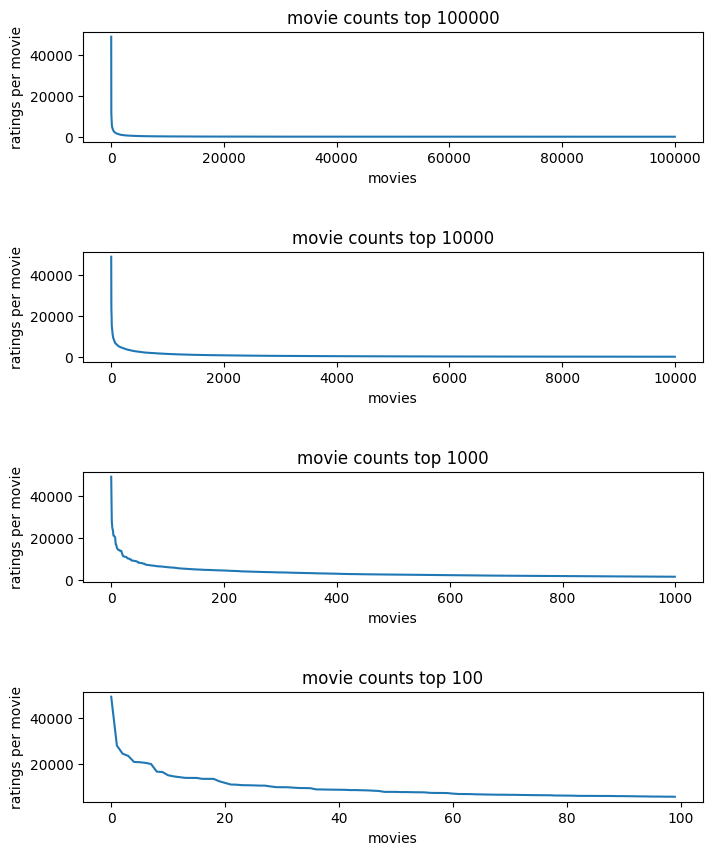

In [31]:
# Create plots for top 100000, 10000, 1000 and 100 items in terms of number of ratings
fig, axs = plt.subplots(4, 1, figsize=(8, 10))

for i in range(4):
    axs[i].plot(np.array(movie_counts.head(100000//(10**i))['count']))
    axs[i].set_title('movie counts top ' + str(100000//(10**i)))
    axs[i].set_xlabel('movies')
    axs[i].set_ylabel('ratings per movie')

plt.subplots_adjust(hspace=1)

The observed distribution exhibits a pronounced long tail across all zoom levels. The discernible "elbow" in the plots appears to lie between 4 and 20. However, selecting such a small value for m would result in an exceedingly limited dataset, comprising only a few movies for which we could generate rating predictions. Our objective is to reduce the size of the rating matrix while also excluding movies with minimal ratings, but we also don't want to exclude too many movies. Thus, we opt to establish a fixed threshold of at least 200 ratings per movie in our subset, rather than specifying a fixed number of movies.

In [32]:
# Create threshold of 200 ratings per item
movie_thresh = movie_counts[movie_counts['count'] <= 199].index[0] - 1

# Create new dataframe containing only movies with at least 200 ratings
movies200ratings = movie_counts.head(movie_thresh)

# Show beginning and end of dataframe
display(movies200ratings)

,itemid,count
0,B00006CXSS,48978
1,B0002ERXC2,28014
2,B00YSG2ZPA,24558
3,B000WGWQG8,23584
4,B00AQVMZKQ,21015
...,...,...
7991,B00B58FURY,200
7992,B000Q5L9N6,200
7993,B00D954AGS,200
7994,B00008HE4B,200


#### Analyzing user counts

Now we repeat the same steps for the user counts.

In [33]:
# Create new dataframe with counts for every userid and rename column accordingly
user_counts = complete_df[['userid', 'rating']].groupby('userid').count().sort_values(by='rating',ascending=False).reset_index()
user_counts.rename(columns={'rating': 'count'},inplace=True)

# Show first 5 lines of dataframe
display(user_counts.head())

,userid,count
0,AV6QDP8Q0ONK4,4543
1,A1GGOC9PVDXW7Z,2760
2,ABO2ZI2Y5DQ9T,2653
3,A328S9RN3U5M68,2566
4,A3LZGLA88K0LA0,2394


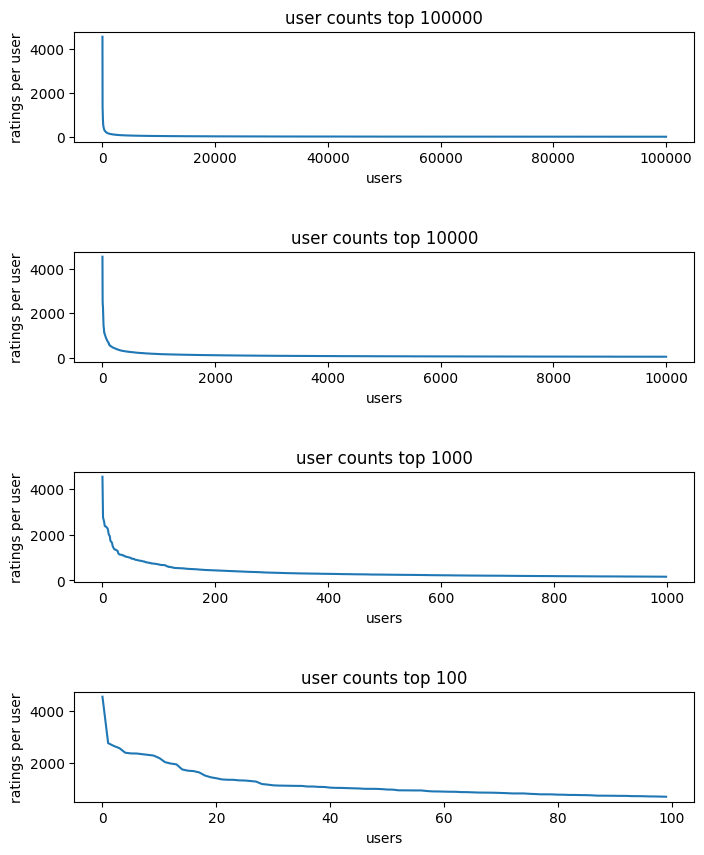

In [34]:
# Create plots for top 100000, 10000, 1000 and 100 users in terms of number of ratings
fig, axs = plt.subplots(4, 1, figsize=(8, 10))

for i in range(4):
    axs[i].plot(np.array(user_counts.head(100000//(10**i))['count']))
    axs[i].set_title('user counts top ' + str(100000//(10**i)))
    axs[i].set_xlabel('users')
    axs[i].set_ylabel('ratings per user')

plt.subplots_adjust(hspace=1)

Once more, our analysis reveals the presence of an "elbow" point characterized by a significantly small number of users. As for the movies, we make a deliberate decision to establish a threshold of 200 ratings, implying that our resulting subset will solely encompass users who have rated at least 200 times.

In [35]:
# Create threshold of 200 ratings per user
user_thresh = user_counts[user_counts['count'] <= 199].index[0] - 1

# Create new dataframe containing only users with at least 200 ratings
users200ratings = user_counts.head(user_thresh)

# Show beginning and end of dataframe
display(users200ratings)

,userid,count
0,AV6QDP8Q0ONK4,4543
1,A1GGOC9PVDXW7Z,2760
2,ABO2ZI2Y5DQ9T,2653
3,A328S9RN3U5M68,2566
4,A3LZGLA88K0LA0,2394
...,...,...
729,A2GK9SBFY1EMV5,202
730,A18EXIAW8NU3DP,202
731,A2GXZX0PTNE9VR,202
732,A31RM5QU797HPJ,201


#### Assessing the new size

Prior to creating our subset, it is crucial to validate that the resulting rating matrix will exhibit a significant reduction in size compared to the matrix generated from the entire dataset. This evaluation ensures that our subset adequately addresses the goal of reducing computational complexity.

In [36]:
# Calculate subset numbers of users and items
subset_users = len(users200ratings)
subset_movies = len(movies200ratings)

# Calculate total number of subset rating matrix and ratio with full rating matrix and print both
subset_matrix_entries = subset_users * subset_movies
ratio_matrix_entries = subset_matrix_entries/full_matrix_entries
print(f"Number of entries in the subset rating matrix: {subset_users:,} * {subset_movies:,} = {subset_matrix_entries:,}")
print(f"Ratio of entries in the subset and full rating matrices: {ratio_matrix_entries}")

Number of entries in the subset rating matrix: 734 * 7,996 = 5,869,064
Ratio of entries in the subset and full rating matrices: 8.44111571049957e-06


#### Creating the subset

The observed ratio between the subset and the complete rating matrix demonstrates a substantial reduction, affirming the successful achievement of our goal to reduce computational complexity. With this confirmation, we now proceed to construct a subset of the complete dataframe, selectively incorporating items and users who have contributed or received a minimum of 200 ratings.

In [37]:
# Create new dataframe with users and items above the threshold of 200 ratings
subset_with_titles = complete_df[(complete_df['itemid'].isin(movies200ratings['itemid'])) & (complete_df['userid'].isin(users200ratings['userid']))]

# Drop titles as they are not necessary for recommender system
subset = subset_with_titles.drop('title', axis=1)

# Change type of discrete ratings to integer
subset['rating'] = subset['rating'].astype(int)

# Reset index after deleting many rows
subset = subset.reset_index()

# Drop old indices
subset = subset.drop('index', axis=1)

# Show first 5 lines of dataframe
display(subset)

,itemid,userid,rating
0,0005019281,A1L2DLWYRNHKDR,2
1,0005019281,A3I4C4LS3ID7Y4,4
2,0005019281,A23M34LR1SQHS9,5
3,0005019281,A1GHUN5HXMHZ89,5
4,0005019281,A2JP0URFHXP6DO,3
...,...,...,...
166314,B01HH7KC60,ANZ7C7H704IZT,4
166315,B01HH7KC60,A1MECEHZHFE5PT,5
166316,B01HH7KC60,AYB0IXBPBJ20A,3
166317,B01HH7KC60,AV6QDP8Q0ONK4,2


#### Creating the rating matrix

Using this subset, we can now generate the rating matrix, which inherently contains numerous missing entries. To facilitate easier manipulation, we fill all the missing entries with zeros.

In [50]:
# Create rating matrix
rating_matrix = subset.pivot_table(index='userid', columns='itemid', values='rating')

# Fill missing entries with zeros
rating_matrix = rating_matrix.fillna(0)

# Show corners of rating matrix
display(rating_matrix)

itemid,0005019281,0005119367,0307142493,0375810331,0767001311,0767015525,0767020294,0767023765,0767087372,0767088247,...,B01GWCDFT2,B01H1VTEMK,B01H2JPTDO,B01H2OWNH4,B01H4FJP7C,B01H4FJR5W,B01H7QA5XG,B01H9HCOP0,B01HC3880G,B01HH7KC60
userid,,,,,,,,,,,,,,,,,,,,,
A10175AMUHOQC4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106016KSI0YQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A106YXO3EHVD3J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10H47FMW8NHII,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ODC971MDHV8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYWSFRCIMOAYE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYZ141IJXKU9W,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZ2YLC0GWTAH2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Comparing sparsities

Given that we have removed users and items with limited ratings from the dataset, the resulting subset should exhibit a lower level of sparsity compared to the full rating matrix. This reduction in sparsity is attributed to the exclusion of sparse entities, enhancing the overall density of the subset and facilitating more meaningful analyses.

In [38]:
# Calculate sparsity for subset and print it
sparsity_subset = 1 - len(subset) / (len(users200ratings) * len(movies200ratings))
print(f"Sparsity of the subset:         {round(sparsity_subset,5)}")

# Calculate sparsity for full dataset and print it
sparsity_fullset = 1 - len(complete_df) / (len(user_counts) * len(movie_counts))
print(f"Sparsity of the full data set:  {round(sparsity_fullset,5)}")

Sparsity of the subset:         0.97166
Sparsity of the full data set:  0.99999


We see that the sparsity indeed is lower for the subset.

## Singular Value Decomposition for Enhanced Rating Predictions

We have successfully loaded, prepared, and selected data from the movies and TV shows subset of the Amazon Review Data. To predict ratings in the still very sparse rating matrix, we employ the Singular Value Decomposition (SVD) technique, which uses matrix factorization.

#### Estimating hyperparameter values

In the initial stage, we make estimations on various hyperparameters that hold potential for achieving desirable outcomes. These hyperparameters encompass key aspects of the SVD algorithm:

- "n_factors" stands for the number of dimensions employed in the matrix factorization process; we set n_factors = 20
- "lr_all" denotes the learning rate for all parameters; to promote efficient learning, we set lr_all = 0.02
- "reg_all" corresponds to the regularization term for all parameters; by setting reg_all = 0.001, we aim to control overfitting by discouraging overly complex models
- "n_epochs" represents the number of iterations for which the model is trained; we set n_epochs = 1000, enabling the algorithm to converge towards an optimal solution through repeated updates

To assess the predictive quality of our model, we employ a simple train and test split approach. The dataset is divided into distinct training and testing sets, enabling the evaluation of performance. In this evaluation, we utilize the root mean squared error (RMSE) metric, which quantifies the average prediction error between the predicted ratings and the actual ratings within the test set. By measuring RMSE, we obtain insights into the accuracy of our predictions and the model's capability to generalize to unseen data.

Runtime should be 20-30 seconds.

In [39]:
# Initialize reader with appropriate rating scale
reader = Reader(rating_scale=(1, 5))

# Construct dataset suitable for SVD algorithm from subset
data = Dataset.load_from_df(subset[['userid', 'itemid', 'rating']], reader)

# Execute train test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Set hyperparameters and train algorithm on trainset
svd_1 = SVD(n_factors=20, lr_all=0.02, reg_all=0.001, n_epochs=1000)
svd_1.fit(trainset)

# Store predictions for the test set
predictions_1 = svd_1.test(testset)

# Show RMSE for SVD with our default values
rmse_1 = accuracy.rmse(predictions_1)
rmse_1

RMSE: 1.0214


1.021443699349526

#### Assessing performance of SVD with estimated hyperparameters

Considering the rating range from 1 to 5, it becomes evident that the observed RMSE value is relatively high. This outcome can be attributed to the inherent sparsity present in the rating matrix, which poses a significant challenge in accurately predicting missing ratings.

To gain further insights, we proceed to examine the predicted ratings more closely. Firstly, we create a dataframe using our predictions. We then add a column to this dataframe that calculates the difference between the actual rating and the predicted rating. Finally, we retrieve a random sample of 10 predictions from this dataframe, allowing us to examine the variation between actual and predicted ratings.

In [40]:
# Create dataframe of predictions for better viewability
predictions_df_1 = pd.DataFrame(predictions_1, columns = ['User ID', 'Item ID', 'True Rating', 'Predicted Rating', 'Details']).drop('Details', axis=1)

# Add column "difference"
predictions_df_1["Difference"] = abs(predictions_df_1["True Rating"] - predictions_df_1["Predicted Rating"])

# Show 10 random lines of the predictions dataframe
display(predictions_df_1.sample(n=10))

,User ID,Item ID,True Rating,Predicted Rating,Difference
22220,A2IY9M330NKBW6,B0090SI4BA,4.0,3.738844,0.261156
24202,APOGXH3A74CM3,B01723F80E,5.0,3.870717,1.129283
7655,A3Q4XAQXKKV6V,6301967364,4.0,3.167719,0.832281
23553,A4SY5RCGC5CH9,B0002235P8,4.0,4.008550,0.008550
28578,A3R2YB0WTTB0IJ,6304981643,5.0,3.756914,1.243086
8402,A1CDNTB7377YH2,630573240X,5.0,5.000000,0.000000
15184,A1NSDP9YZXLMDX,B014HDTT84,5.0,5.000000,0.000000
13446,A1G0VFQ9198IUF,630420065X,5.0,5.000000,0.000000
11187,A18G7GG53G2X8A,B00188M5TM,5.0,4.486924,0.513076
1421,A9Q28YTLYREO7,6304342462,1.0,5.000000,4.000000


To gain a deeper understanding of the deviations from perfect predictions, we will focus on examining the ratings for a specific user. For the purpose of this analysis, we arbitrarily select user 'A106016KSI0YQ'. We will plot the true ratings against the predicted ratings, enabling us to visualize the disparities between the actual and predicted values for this user.

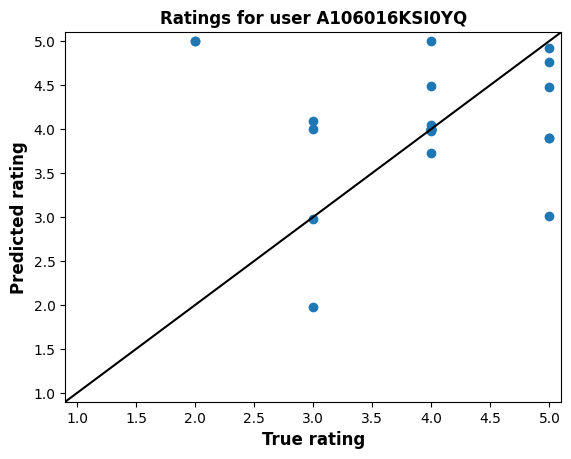

In [41]:
# Show all rating predictions for one specific user
userid = 'A106016KSI0YQ'
user_ratings = predictions_df_1[predictions_df_1['User ID'] == userid]

# Plot true ratings vs predicted ratings
plt.plot(user_ratings["True Rating"], user_ratings["Predicted Rating"], marker="o", linestyle="None")
plt.title(f"Ratings for user {userid}", loc = 'center', fontweight="bold")
plt.xlabel("True rating", fontweight = "bold", fontsize = 12)
plt.ylabel("Predicted rating", fontweight = "bold", fontsize = 12)
plt.xlim(left=0.9, right=5.1)
plt.ylim(bottom=0.9, top=5.1)

# Draw line to make locations of perfect predictions visible
plt.plot([0, 6], [0, 6], color="black")

The obtained plot aligns with our expectations, as the relatively high RMSE value indicates significant deviations of certain ratings from the "perfect predictions line" (represented by the black line in the plot). To improve the results, our next step involves optimizing the algorithm, aiming to enhance the accuracy and reduce the discrepancies between the actual and predicted ratings.

## Hyperparameter Optimization

To enhance the accuracy and performance of our recommender system, we engage in a thorough analysis of the hyperparameters employed in the Singular Value Decomposition (SVD) approach. Leveraging grid search as our optimization technique, we meticulously fine-tune these hyperparameters to achieve optimal results. In addition, we utilize cross-validation to ensure robust evaluation of the model's generalization capabilities. This involves employing separate training and validation sets throughout the grid search process.

#### First Grid Search

Our initial focus is on optimizing the hyperparameter known as "n_factors" or "k." This parameter determines the number of dimensions used in the matrix factorization process and plays a critical role in the complexity and expressiveness of our model. By increasing the value of n_factors, the model gains the ability to capture intricate patterns and subtle nuances in the data. However, this also leads to increased computational complexity and the risk of overfitting. Conversely, reducing the value of n_factors limits the model's ability to capture complex relationships but may improve its generalization capabilities. We perform an exhaustive search of different values specified within the param_grid to determine the optimal value for n_factors. Additionally, we reduce the number of iterations from 1000 to 100 to ensure efficient execution while still evaluating a range of diverse hyperparameters.

In the second step, we will then proceed to tune the hyperparameters "lr_all" (learning rate for all parameters) and "reg_all" (regularization term for all parameters) based on the selected value of n_factors. We perform this tuning separately to avoid a significant increase in the number of combinations that the grid search must explore. By decoupling the optimization process, we can maintain a reasonable runtime for the grid searches. The expected runtime for the first grid search is approximately 30 seconds, while the second grid search is anticipated to take around 90 seconds.

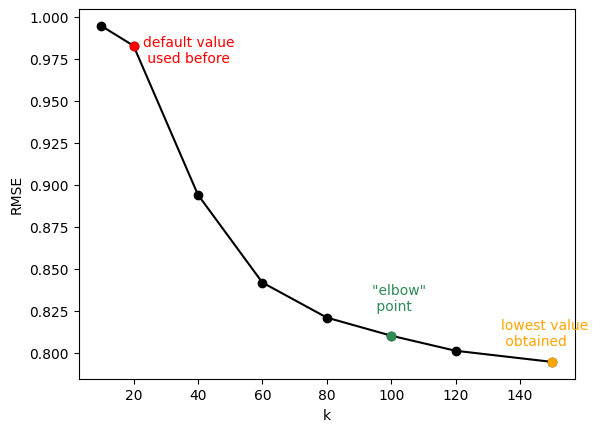

In [42]:
# Create parameter grid for gridsearch
param_grid_1 = {
    'n_factors': [10, 20, 40, 60, 80, 100, 120, 150],
    'n_epochs': [100],
    'lr_all': [0.02],
    'reg_all': [0.001],
    'random_state': [42]  # Fixed value for reproducibility
}

# Execute gridsearch on data
grid_search_1 = GridSearchCV(SVD, param_grid_1, measures=['rmse'], cv=3, refit=True, n_jobs=-1, ra)
grid_search_1.fit(data)

# Plot RMSE values vs. corresponding number of n_factors
n_factors = param_grid_1["n_factors"]
rmse_results_1 = grid_search_1.cv_results["mean_test_rmse"]
plt.plot(n_factors, rmse_results_1, marker="o", linestyle="-", color="black")

# Store values for highlighting specific points
default_k = param_grid_1["n_factors"].index(20)
lowest_k = np.argmin(rmse_results_1)
elbow_k = 5

# Highlight default value in plot
plt.plot(n_factors[default_k], rmse_results_1[default_k], marker="o", color="red")
plt.text(n_factors[default_k]+3, rmse_results_1[default_k]-0.01, "default value \n used before", color="red")

# Highlight "elbow point" in plot
plt.plot(n_factors[elbow_k], rmse_results_1[elbow_k], marker="o", color="seagreen")
plt.text(n_factors[elbow_k]-6, rmse_results_1[elbow_k]+0.015, "\"elbow\" \n point", color="seagreen")

# Highlight lowest RMSE value in plot
plt.plot(n_factors[lowest_k], rmse_results_1[lowest_k], marker="o", color="orange")
plt.text(n_factors[lowest_k]-16, rmse_results_1[lowest_k]+0.01, "lowest value \n obtained", color="orange")

# Label axes
plt.ylabel("RMSE")
plt.xlabel("k")

plt.show()

To simplify the decision-making process, we opt not to perform an elaborate computation to identify the precise location of the elbow on the plot. Instead, we rely on visual analysis to determine an appropriate value for the hyperparameter k. Upon careful examination, we notice a distinct elbow at k=100, which corresponds to a significant reduction in RMSE. Considering the complexity and overfitting concerns previously mentioned, we strive to select the smallest feasible value for k that yields a low RMSE.

To evaluate the impact of this decision, we compare the absolute RMSE values obtained before and after adjusting the value of k. By calculating the difference between these two RMSE values, we can quantify the improvement achieved through the adjustment in k.

In [43]:
# Store RMSE values and print them and their difference
RMSE_default = rmse_results_1[default_k]
RMSE_elbow = rmse_results_1[elbow_k]
print(f"RMSE for k=20:  {round(RMSE_default,4)}")
print(f"RMSE for k=100: {round(RMSE_elbow,4)}")
print(f"Difference:     {round(RMSE_default - RMSE_elbow,4)}")


RMSE for k=20:  0.9829
RMSE for k=100: 0.8101
Difference:     0.1728


#### Second Grid Search

The findings from our first grid search align with the observations made in the plot, indicating a substantial reduction in RMSE for the chosen value of k=100 compared to k=20. Building upon this insight, we proceed to conduct a second round of hyperparameter tuning, focusing on the variables lr_all (learning rate for all parameters) and reg_all (regularization term for all parameters). This grid search involves exploring various combinations of lr_all and reg_all while keeping the value of n_factors fixed at 100. By optimizing these hyperparameters, we aim to further improve the performance and accuracy of our recommender system.

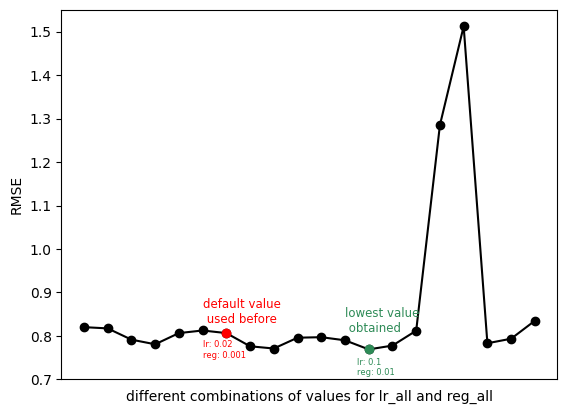

In [44]:
# Create parameter grid for second gridsearch
param_grid_2 = {
    'n_factors': [100],
    'n_epochs': [100],
    'lr_all': [0.005, 0.02, 0.1, 0.15],
    'reg_all': [0.0005, 0.001, 0.01, 0.05, 0.1],
    'random_state': [42]  # Fixed value for reproducibility
}

# Execute second gridsearch on data
grid_search_2 = GridSearchCV(SVD, param_grid_2, measures=['rmse'], cv=3, refit=True, n_jobs=-1)
grid_search_2.fit(data)

# Store value for lowest RMSE value
rmse_results_2 = grid_search_2.cv_results["mean_test_rmse"]
lowest = np.argmin(rmse_results_2)

# Plot RMSE values
x = list(range(1, 21))
default = 6
plt.plot(x,rmse_results_2, marker="o", linestyle="-", color="black")
plt.ylim(bottom=0.7, top=1.55)

# Highlight default value in plot
plt.plot(x[default], rmse_results_2[default], marker="o", color="red")
plt.text(6, 0.83, "default value \n used before", color="red", fontsize=8.5)
plt.text(6, 0.75, "lr: 0.02\nreg: 0.001", color="red", fontsize=6)

# Highlight lowest value in plot
plt.plot(x[lowest], rmse_results_2[lowest], marker="o", color="seagreen")
plt.text(12, 0.81, "lowest value \n obtained", color="seagreen", fontsize=8.5)
plt.text(12.5, 0.71, "lr: 0.1\nreg: 0.01", color="seagreen", fontsize=6)

# Label axes and remove ticks (numbers on x axis don't have meaning here)
plt.ylabel("RMSE")
plt.xlabel("different combinations of values for lr_all and reg_all")
plt.xticks([])

plt.show()


The results from the second grid search using cross-validation demonstrate the potential to further reduce the RMSE value. It's worth noting that due to simplicity reasons, the additional notes on the plot were rearranged after obtaining the scores and calculating the RMSE values. However, we can still assess the significance of the change by calculating the difference between the two RMSE values.

In [45]:
# Store RMSE values and print them and their difference
RMSE_lowest = rmse_results_2[lowest]
print(f"RMSE for default values:  {round(RMSE_default,4)}")
print(f"RMSE for found values:    {round(RMSE_lowest,4)}")
print(f"Difference:               {round(RMSE_elbow - RMSE_lowest,4)}")

RMSE for default values:  0.9829
RMSE for found values:    0.7691
Difference:               0.041


Despite the smaller difference in RMSE values compared to the initial run of grid search, the significance remains notable, considering the scale of 1 to 5. Therefore, it is advisable to incorporate the optimized hyperparameter values into a second round of running Singular Value Decomposition (SVD). 

## SVD with optimized hyperparameters

In this round, we increase the number of epochs to 1000 for better convergence and improved results. By comparing the resulting RMSE value from this optimized run with the one obtained from the initial SVD run, we can assess the effectiveness of the hyperparameter optimization process.

The expected runtime for this second round of SVD with optimized hyperparameters is approximately 60 seconds.

In [46]:
# Set hyperparameters and train algorithm on trainset
svd_2 = SVD(n_factors=100, lr_all=0.1, reg_all=0.01, n_epochs=1000)
svd_2.fit(trainset)

# Store new RMSE value
predictions_2 = svd_2.test(testset)
rmse_2 = accuracy.rmse(predictions_2, verbose=False)

# Print RMSE values for first and second run of SVD and their difference
print(f"RMSE for SVD with n_factors = 20, lr_all = 0.02, reg_all = 0.001 (First SVD training): \n{rmse_1.round(4)}")
print(f"\nRMSE for SVD with n_factors = 100, lr_all = 0.1, reg_all = 0.01 (Second SVD training): \n{rmse_2.round(4)}")
print(f"\nDifference in RMSE between both hyperparameter sets: \n{round(rmse_1 - rmse_2, 4)}")

RMSE for SVD with n_factors = 20, lr_all = 0.02, reg_all = 0.001 (First SVD training): 
1.0214

RMSE for SVD with n_factors = 100, lr_all = 0.1, reg_all = 0.01 (Second SVD training): 
0.731

Difference in RMSE between both hyperparameter sets: 
0.2904


#### Assessing performance of SVD with optimized hyperparameters

To evaluate the performance of the SVD model with the optimized hyperparameters, we create a dataframe from the predictions and plot the true ratings versus the predicted ratings. In addition, we overlay the values from the first SVD run in a different color, making the dots half transparent to ensure the visibility of layered dots.

This comparison allows us to visually analyze the improvements achieved through the hyperparameter optimization process and observe any changes in the alignment between the predicted and true ratings. By assessing the overlap and distribution of the data points, we can gain insights into the effectiveness of the optimization efforts in reducing the prediction errors and enhancing the accuracy of the recommender system.

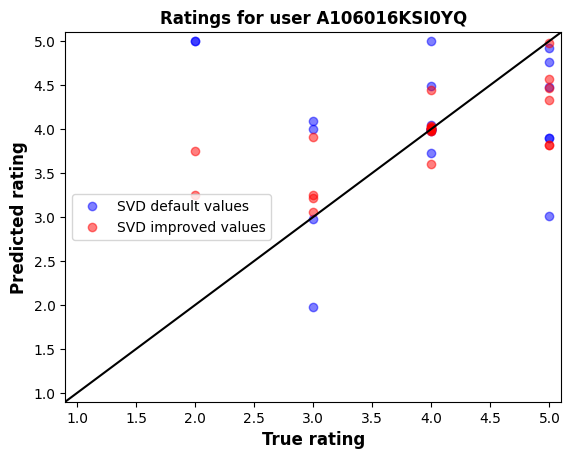

In [47]:
# Create dataframe of predictions for predictions_2
predictions_df_2 = pd.DataFrame(predictions_2, columns = ['User ID', 'Item ID', 'True Rating', 'Predicted Rating', 'Details']).drop('Details', axis=1)

# Add column "difference" again
predictions_df_2["Difference"] = abs(predictions_df_2["True Rating"] - predictions_df_2["Predicted Rating"])

# Store all rating predictions of predictions_2 for the same user as before
user_ratings_2 = predictions_df_2[predictions_df_2['User ID'] == userid]

# Plot true ratings vs predicted ratings for 1st and 2nd run of SVD, make dots half transparent so layered dots stay visible
plt.plot(user_ratings["True Rating"], user_ratings["Predicted Rating"], marker="o", linestyle="None", color="blue", alpha=0.5)
plt.plot(user_ratings_2["True Rating"], user_ratings_2["Predicted Rating"], marker="o", linestyle="None", color="red", alpha=0.5)
plt.title(f"Ratings for user {userid}", loc = 'center', fontweight="bold")
plt.xlabel("True rating", fontweight = "bold", fontsize = 12)
plt.ylabel("Predicted rating", fontweight = "bold", fontsize = 12)
plt.xlim(left=0.9, right=5.1)
plt.ylim(bottom=0.9, top=5.1)
plt.legend([f"SVD default values", f"SVD improved values"], loc="center left")

# Draw line to show locations of "perfect predictions"
plt.plot([0, 6], [0, 6], color="black")

As before, we will focus solely on the visual analysis of the plot without performing any calculations. Upon observing the plot, it becomes apparent that the red dots, representing the second run of SVD with optimized hyperparameters, are noticeably closer to the perfect predictions line compared to the blue dots, representing the first run. This visual observation implies that the adjustment to the hyperparameters in the second model has likely resulted in improved prediction performance for this particular user. The closer alignment between the predicted and true ratings suggests enhanced accuracy in capturing user preferences and predicting ratings for unrated items.

## Recommendation generation

We will proceed with training the SVD model on the full dataset using the optimal hyperparameters obtained from the second gridsearch. This time, we will generate recommendations for the same random user we previously analyzed and compare them with the user's actual top ratings. We will utilize the "movie_titles" dataframe created at the beginning, which provides the actual movie titles.

The runtime for this process is estimated to be approximately 60 seconds.

In [51]:
# Create trainset from entire dataset
trainset = data.build_full_trainset()

# Execute svd for third time, on whole dataset
svd_3 = SVD(n_factors=100, lr_all=0.1, reg_all=0.01, n_epochs=1000)
svd_3.fit(trainset)

# Create recommendations for unrated movies for the same user we looked at before
recommendations = []
for i in range(len(rating_matrix.loc[userid])):
    if rating_matrix.loc[userid][i] == 0:
        pred = svd_3.predict(userid, rating_matrix.columns[i])
        recommendations.append(pred)

# Create dataframe of recommendations for this user
recommendations_df = pd.DataFrame(recommendations, columns = ['User ID', 'Item ID', 'True Rating', 'Predicted Rating', 'Details']).drop(['User ID', 'True Rating', 'Details'], axis=1)

# Create dataframe of top 10 recommendations for this user
top_10_recommendations = recommendations_df.sort_values(by="Predicted Rating", ascending=False).head(10)
top_10_recommendations = top_10_recommendations.merge(movie_titles, left_on="Item ID", right_on="itemid").drop('itemid', axis=1).drop_duplicates()

# Create dataframe of top 10 rated movies for this user
top_10_ratings = user_ratings.sort_values(by="True Rating", ascending=False).head(10)
top_10_ratings = top_10_ratings.drop(['User ID', 'Predicted Rating', 'Difference'], axis=1).merge(movie_titles, left_on="Item ID", right_on="itemid")
top_10_ratings = top_10_ratings.drop_duplicates().drop('itemid', axis=1)

# Show top recommendations and top ratings
display(top_10_recommendations)
display(top_10_ratings)


,Item ID,Predicted Rating,title
0,6305191883,5.000000,Henry: Portrait of a Serial Killer
1,0790729733,5.000000,JFK Director's Cut
2,B00005JOZI,5.000000,United 93
4,6302719666,4.997645,Stalker VHS
5,6303338569,4.946273,Holocaust EP mode VHS
6,B00003CXXI,4.902758,Shrek VHS
8,6303980813,4.886206,"I, Claudius VHS"
9,6300183513,4.864144,Rear Window VHS
10,0790729377,4.814517,A Streetcar Named Desire
11,6302800897,4.813665,Anatomy of a Murder VHS


,Item ID,True Rating,title
0,6300217728,5.0,The Red Shoes VHS
1,B00005ALS0,5.0,Best in Show
3,B000YABIQ6,5.0,Mad Men: Season 1
5,B000HEVTOU,5.0,Don't Look Now Region 2
6,B0007N1BBC,5.0,North and South Set North &amp; South NON-USA...
7,B00004S322,4.0,Gormenghast
9,B00003CX8I,4.0,X-Men VHS
11,B00006FHZE,4.0,"The Forsyte Saga, Series 1"
13,B00005JPB0,4.0,Infamous


Due to the lack of additional metadata about the movies, such as genres or other relevant information, it becomes challenging to assess the extent to which the recommendations align with the user's preferences based on their top 10 true ratings. Without this contextual information, it is difficult to make conclusive statements about the overall performance of the recommender system.

To perform a more comprehensive evaluation and draw meaningful conclusions about the system's effectiveness, additional testing procedures and analysis methods that consider a wider range of factors would be necessary. However, such procedures would exceed the scope of this project.

Given the limitations of the available data and the absence of genre or other metadata information, it is not feasible to make conclusive assessments regarding the performance and accuracy of the recommender system in matching the user's preferences.

## Conclusion

In this project, we have successfully implemented a recommender system using matrix factorization with singular value decomposition (SVD). We followed a systematic approach, starting with data preparation and progressing to model training and optimization.

The initial phase involved loading and preparing the data to meet the requirements of our recommender system. We then trained the SVD model using user-specified hyperparameters and evaluated its performance using the root mean square error (RMSE) metric.

To improve the predictive capabilities of the model, we conducted hyperparameter optimization through grid search cross-validation. Our focus was on optimizing the n_factors, lr_all, and reg_all hyperparameters of the SVD model. Throughout the optimization process, we carefully considered the trade-off between model complexity and generalization performance. Based on our evaluations, we selected specific hyperparameter values, including n_factors=100, lr_all=0.1, and reg_all=0.01, which demonstrated improved prediction accuracy compared to other combinations.

Furthermore, we assessed the model's performance by comparing the predicted ratings with the actual ratings for a chosen user. The second model, with optimized hyperparameters, exhibited superior prediction accuracy for a user chosen at random, suggesting the effectiveness of our hyperparameter optimization approach.

Finally, we generated recommendations using the optimized SVD model and compared them to the user's top-rated movies. While this comparison provided valuable insights, we acknowledged the need for a more comprehensive evaluation approach. Considering additional factors such as user feedback, movie genres, actors, and other relevant metrics would further enhance our understanding of the model's performance.

Overall, this project highlights the importance of data preparation, hyperparameter optimization, and evaluation techniques in building effective recommender systems. By employing matrix factorization and SVD, we have demonstrated the potential for accurate predictions and personalized recommendations in real-world applications.

## References
<a id="1">[1]</a> 
**Amazon Review Data (2018)**\
Jianmo Ni, 2019.\
Available: <br>
*Direct Link [Last Accessed: 08 June 2023]:* <br>
 https://nijianmo.github.io/amazon/index.html\